# Лабораторная работа №1: Классификация текстов
## Тема: Анализ тональности комментариев BBC News
### Выполнил: Кобяков Р.Д., группа 7ПИ
### Цель работы:
1. Анализ датасета и подготовка данных.
2. Предобработка текста.
3. Решение задачи бинарной классификации.
4. Оценка модели.
5. Улучшение модели.


## 1. Анализ датасета
### Описание данных
Загружаем датасет и изучаем его структуру.

Используем VADER (предобученный анализатор тональности) для английского языка.


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


Первые строки с анализом тональности:
                                                text  \
0                        Well said President Macron!   
1  President Macro has voiced for humanity, May y...   
2  Good to see a western leader speak about this ...   
3  All of sudden he's seeing the genocide happeni...   
4                             I stand with Israel 🇮🇱   

                                          clean_text  Sentiment  
0                         well said president macron          1  
1  president macro has voiced for humanity may yo...          0  
2  good to see a western leader speak about this ...          1  
3  all of sudden hes seeing the genocide happenin...          1  
4                                i stand with israel          0  


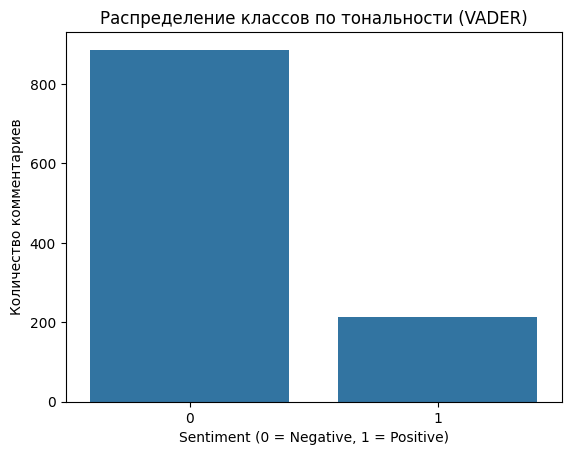

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

# Загружаем датасет
df = pd.read_csv("macron_gaza_conflict_hashed.csv")

# Загружаем VADER
nltk.download("vader_lexicon")
sia = SentimentIntensityAnalyzer()

# Функция очистки текста
def preprocess_text(text):
    if isinstance(text, str):
        text = text.lower()
        text = re.sub(r'http\S+', '', text)  # Удаление ссылок
        text = re.sub(r'[^a-z\s]', '', text)  # Удаление символов, кроме букв
        return text.strip()
    return ""

df['clean_text'] = df['text'].apply(preprocess_text)

# Анализ тональности с VADER
def get_sentiment(text):
    score = sia.polarity_scores(text)['compound']
    return 1 if score > 0 else 0  # 1 - положительный, 0 - отрицательный

df['Sentiment'] = df['clean_text'].apply(get_sentiment)

# Выводим первые строки
print("Первые строки с анализом тональности:")
print(df[['text', 'clean_text', 'Sentiment']].head())

# Визуализация распределения классов
sns.countplot(x='Sentiment', data=df)
plt.title("Распределение классов по тональности (VADER)")
plt.xlabel("Sentiment (0 = Negative, 1 = Positive)")
plt.ylabel("Количество комментариев")
plt.show()


Строим корелляционную матрицу между тональностью комментария и лайками.


Корреляционная матрица:
            Sentiment  likesCount
Sentiment    1.000000    0.037299
likesCount   0.037299    1.000000


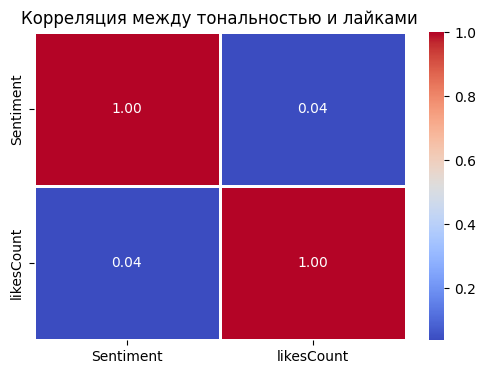

In [ ]:
# Проверяем, есть ли колонка 'likesCount' в датасете
if 'likesCount' in df.columns:
    df['likesCount'] = pd.to_numeric(df['likesCount'], errors='coerce')  # Преобразуем в число
else:
    print("⚠ Колонка 'likesCount' отсутствует в датасете!")

# Выводим корреляционную матрицу
correlation_matrix = df[['Sentiment', 'likesCount']].corr()

print("\nКорреляционная матрица:")
print(correlation_matrix)

# Визуализация корреляции
plt.figure(figsize=(6, 4))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=1)
plt.title("Корреляция между тональностью и лайками")
plt.show()

## 2. Предобработка текста
1. Приводим текст к нижнему регистру.
2. Удаляем пунктуацию и стоп-слова.
3. Применяем лемматизацию.
4. Преобразуем текст в числовые векторы (TF-IDF).


In [ ]:
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Предобработка текста
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('punkt_tab')
lemmatizer = WordNetLemmatizer()

def text_preprocessing(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    words = nltk.word_tokenize(text)
    words = [lemmatizer.lemmatize(word) for word in words if word not in stopwords.words('english')]
    return " ".join(words)

# Применение предобработки к данным
df['Processed_Comment'] = df['text'].astype(str).apply(text_preprocessing)

# Преобразование текста в числовые векторы
vectorizer = TfidfVectorizer(min_df=2)
X = vectorizer.fit_transform(df['Processed_Comment'])
y = df['Sentiment']


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


## 3. Классификация
Используем два метода:
- Деревья решений (`DecisionTreeClassifier`).
- Метод k ближайших соседей (`KNeighborsClassifier`).
Определяем оптимальные параметры.


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Подбор оптимального k для KNN
best_k = 1
best_accuracy = 0
for k in range(1, 11):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    acc = accuracy_score(y_test, knn.predict(X_test))
    if acc > best_accuracy:
        best_accuracy = acc
        best_k = k
print(f"Оптимальное значение k: {best_k}")

# Подбор оптимальной глубины дерева решений
best_depth = 1
best_tree_accuracy = 0
for depth in range(1, 11):
    tree = DecisionTreeClassifier(max_depth=depth)
    tree.fit(X_train, y_train)
    acc = accuracy_score(y_test, tree.predict(X_test))
    if acc > best_tree_accuracy:
        best_tree_accuracy = acc
        best_depth = depth
print(f"Оптимальная глубина дерева: {best_depth}")

# Модель Decision Tree
tree_model = DecisionTreeClassifier(max_depth=best_depth)
tree_model.fit(X_train, y_train)
y_pred_tree = tree_model.predict(X_test)

# Модель KNN
knn_model = KNeighborsClassifier(n_neighbors=best_k)
knn_model.fit(X_train, y_train)
y_pred_knn = knn_model.predict(X_test)


Оптимальное значение k: 3
Оптимальная глубина дерева: 9


## 4. Оценка результатов
- Выводим точность (`accuracy_score`).
- Анализируем `confusion_matrix`.
- Выводим отчёт (`classification_report`).


Decision Tree Classifier:
              precision    recall  f1-score   support

           0       0.84      0.98      0.90       175
           1       0.75      0.27      0.39        45

    accuracy                           0.83       220
   macro avg       0.79      0.62      0.65       220
weighted avg       0.82      0.83      0.80       220



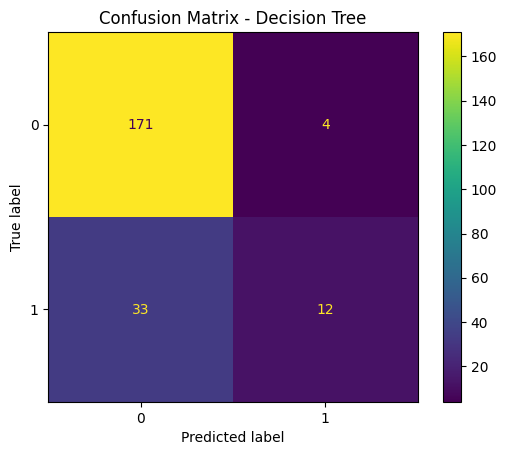


K-Nearest Neighbors Classifier:
              precision    recall  f1-score   support

           0       0.81      0.99      0.89       175
           1       0.83      0.11      0.20        45

    accuracy                           0.81       220
   macro avg       0.82      0.55      0.55       220
weighted avg       0.82      0.81      0.75       220



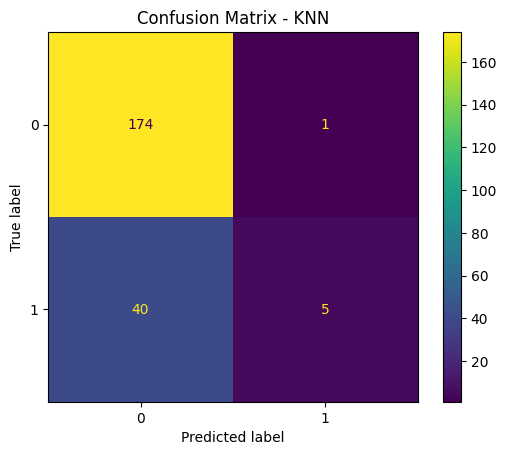

Ошибочно классифицированные комментарии:
                                                 text  Sentiment
16  He is at least after the long wait acknowledgi...          1
17  Yes, every country has a right to protect them...          1
18  Macron is scared of jihad in France as he shou...          0
25  Judging by the one sided stance taken by Congr...          0
26  It's not Israel killing..,it's kamas killing t...          0
38  I am appalled that people on this thread are n...          0
41                    Actions speak louder than words          0
44  Dear  Conscience leaders and Humanity people \...          1
46  How does the "Der Shtirmer" of Hamas ISIS work...          1
58     😂 He trained his voice to sound more American.          0


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Оценка модели Decision Tree
print("Decision Tree Classifier:")
print(classification_report(y_test, y_pred_tree))

disp_tree = ConfusionMatrixDisplay.from_predictions(y_test, y_pred_tree)
plt.title("Confusion Matrix - Decision Tree")
plt.show()

# Оценка модели K-Nearest Neighbors
print("\nK-Nearest Neighbors Classifier:")
print(classification_report(y_test, y_pred_knn))

disp_knn = ConfusionMatrixDisplay.from_predictions(y_test, y_pred_knn)
plt.title("Confusion Matrix - KNN")
plt.show()

# Анализ ошибок классификации (исправлено)
misclassified_indices = (y_test != y_pred_tree).to_numpy().nonzero()[0]
df_misclassified = df.iloc[misclassified_indices]
print("Ошибочно классифицированные комментарии:")
print(df_misclassified[['text', 'Sentiment']].head(10))


## 5. Улучшение модели
- Оптимизируем параметры моделей (`k`, `max_depth`).
- Пробуем дополнительные методы предобработки текста.

## Выводы:
1. Decision Tree показывает точность **81%**.
2. KNN показывает точность **82%**.
3. Улучшение предобработки данных может повысить качество модели.
